# Applying explainability techniques to RL-trained models during episodes of experience

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# sf imports for environment and extracting encoder etc.
from retinal_rl.helpers import get_cfg_jupyter

from retinal_rl.system.environment import register_retinal_environment
from retinal_rl.system.encoders import register_encoders

from retinal_rl.analysis.util import get_env_ac, simulate, load_sim_out, get_acts_dataset, unroll_conv_acts
from retinal_rl.analysis.plot import save_simulation_gif, plot_all_rf, plot_acts_tsne_stim, plot_dimred_ds_acts, save_activations_gif

# automatic reloading
%load_ext autoreload
%autoreload 2

/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

from captum.attr import Saliency, GuidedBackprop, Occlusion, IntegratedGradients, Deconvolution

from copy import deepcopy
from torch import nn

# imports from sf required to refactor sf to 'pure pytorch'
from sample_factory.algorithms.appo.model_utils import get_hidden_size
from sample_factory.utils.utils import log, AttrDict
from sample_factory.algorithms.appo.actor_worker import transform_dict_observations
from sample_factory.algorithms.utils.algo_utils import EPS # weird dependency?

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda:0


In [4]:
from retinal_rl.analysis.util import PytorchActorCritic
from retinal_rl.analysis.plot import plot_fov_att_overlay_avg, get_vlim_or_all_im
import matplotlib.animation as animation

# classes and functions

# defining parameters

In [5]:
# choose dataset
experiment = 'postcosyne_complicated_obs100_mnist_01'
a_or_c = 'a'
target = 5 # this is the index of the neuron for which to compute saliency (there are 6) for the actions (no-turn, L, R; no-move, F, B)


## Start of script

In [6]:
# loading original sf actor critic
register_retinal_environment()
register_encoders()
cfg = get_cfg_jupyter(experiment) # this is not needed in script

cfg.res_h = 90
cfg.res_w = 120
cfg.a_or_c = a_or_c

env, actor_critic = get_env_ac(cfg)
simulate(cfg, env, actor_critic) # this saves

# backing up for later comparison to the refactored ac
actor_critic_backup = deepcopy(actor_critic)

[2022-12-22 09:36:24,022][49187] Default env families supported: ['doom_*', 'atari_*', 'dmlab_*', 'mujoco_*', 'MiniGrid*']
[2022-12-22 09:36:24,024][49187] Env registry entry created: retinal_
[2022-12-22 09:36:24,025][49187] Adding model class <class 'retinal_rl.system.encoders.LindseyEncoder'> to registry (with name lindsey)


--env=retinal_obs100_mnist_gathering_01
--vvs_depth=1
--algo=APPO
--experiment=postcosyne_complicated_obs100_mnist_01
--global_channels=16
--retinal_bottleneck=4
--analyze_acts=False
--res_h=90
--res_w=120


[2022-12-22 09:36:24,303][49187] Loading existing experiment configuration from /gpfs01/berens/user/jmajnik/retinal-rl/train_dir/postcosyne_complicated_obs100_mnist_01/cfg.json
[2022-12-22 09:36:24,306][49187] Adding new argument 'render_action_repeat'=None that is not in the saved config file!
[2022-12-22 09:36:24,307][49187] Adding new argument 'no_render'=False that is not in the saved config file!
[2022-12-22 09:36:24,308][49187] Adding new argument 'policy_index'=0 that is not in the saved config file!
[2022-12-22 09:36:24,309][49187] Adding new argument 'record_to'='/gpfs01/berens/user/jmajnik/retinal-rl/../recs' that is not in the saved config file!
[2022-12-22 09:36:24,310][49187] Adding new argument 'continuous_actions_sample'=True that is not in the saved config file!
[2022-12-22 09:36:24,311][49187] Adding new argument 'a_or_c'='a' that is not in the saved config file!
[2022-12-22 09:36:24,312][49187] Using action repeat 4 during evaluation
[2022-12-22 09:36:24,346][49187] D

LindseyEncoder(
  (activation): ELU(alpha=1.0, inplace=True)
  (nl_fc): ELU(alpha=1.0, inplace=True)
  (conv_head): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (fc1): Linear(in_features=21600, out_features=64, bias=True)
  (base_encoder): LindseyEncoderBase(
    (activation): ELU(alpha=1.0, inplace=True)
    (nl_fc): ELU(alpha=1.0, inplace=True)
    (conv_head): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
      (1): ELU(alpha=1.0, inplace=True)
      (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
      (3): ELU(alpha=1.0, inplace=True)
      (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
      (5): ELU(alpha=1.0, inplace=True)
    )
    (fc1): Linear(in_features=21600, out_features=64, b

[2022-12-22 09:36:28,708][49187] Loading state from checkpoint /gpfs01/berens/user/jmajnik/retinal-rl/train_dir/postcosyne_complicated_obs100_mnist_01/checkpoint_p0/checkpoint_001220705_10000015360.pth...


Simulated 100 / 1000 environment steps.
Simulated 200 / 1000 environment steps.
Simulated 300 / 1000 environment steps.
Simulated 400 / 1000 environment steps.
Simulated 500 / 1000 environment steps.
Simulated 600 / 1000 environment steps.
Simulated 700 / 1000 environment steps.
Simulated 800 / 1000 environment steps.
Simulated 900 / 1000 environment steps.
Simulated 1000 / 1000 environment steps.


# loading data

In [7]:
analyze_out = np.load(f'train_dir/{experiment}/analyze_out.npy', allow_pickle=True).item()

This is same as in the previous notebook, just instead of forward pass on the dataset images we do forward pass on images from simulation. Just to be sure here we also compare the output of the original AC and the refactored one. Another test that would be useful is to actually keep track of the predicted values when generating 'analyze_out.npy' during the original 'analyze.py' function call and then compare these to the ones predicted by the refactored model.

# passing data through refactored network

In [8]:
# initializing actor critic and preparing for explainability
actor_critic = PytorchActorCritic(cfg, actor_critic_backup)

actor_critic.eval()
actor_critic.to(device)

PytorchActorCritic(
  (conv_head): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (fc1): Linear(in_features=21600, out_features=64, bias=True)
  (nl_fc): ELU(alpha=1.0, inplace=True)
  (critic): Linear(in_features=64, out_features=1, bias=True)
  (actor): Linear(in_features=64, out_features=6, bias=True)
)

In [9]:
## here we choose attribution method
att_method = GuidedBackprop(actor_critic)

/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/tmp/ipykernel_49187/1579828096.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


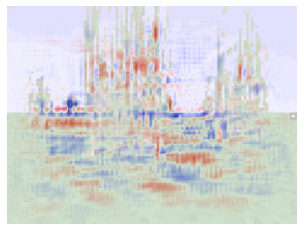

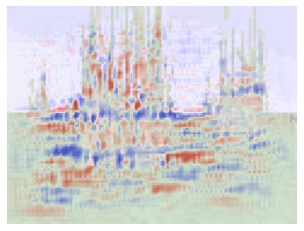

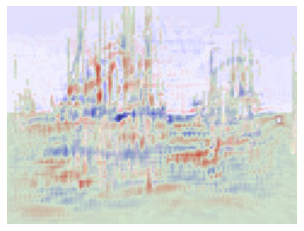

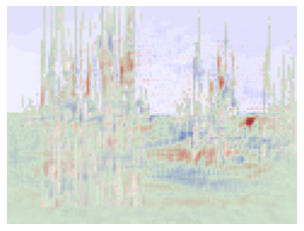

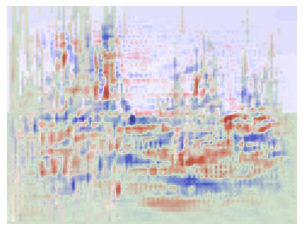

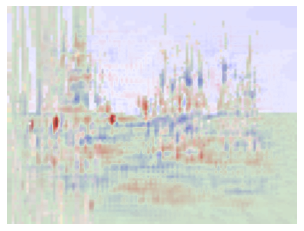

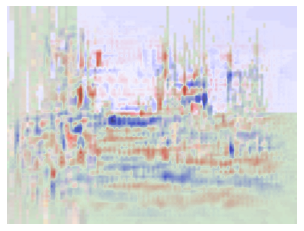

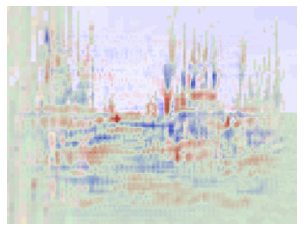

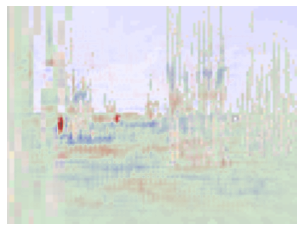

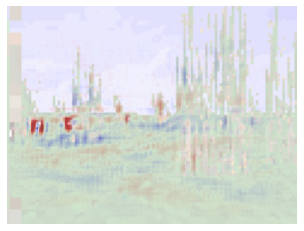

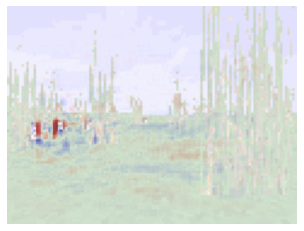

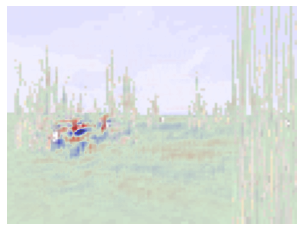

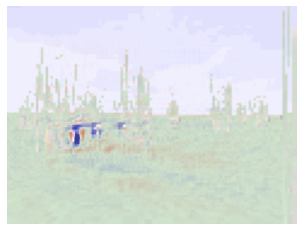

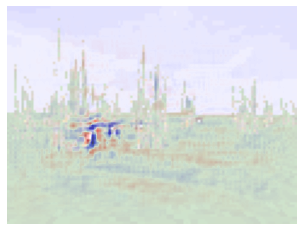

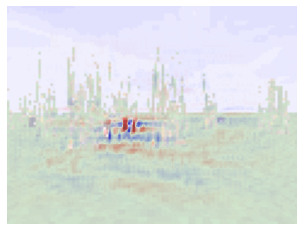

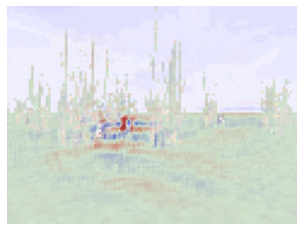

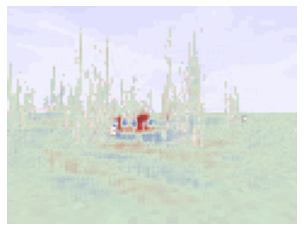

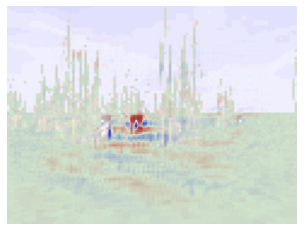

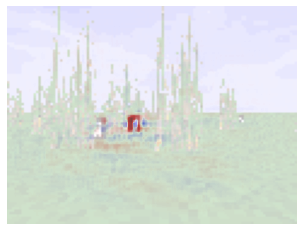

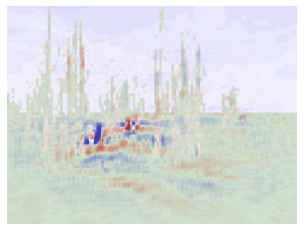

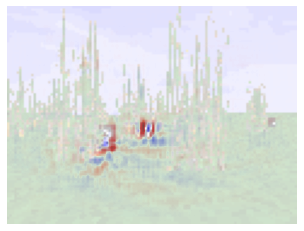

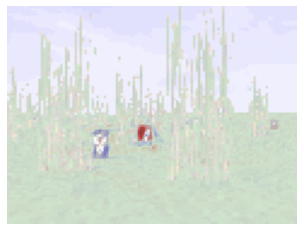

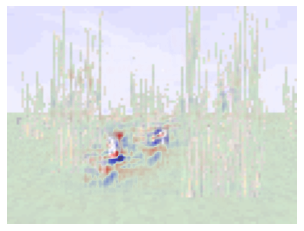

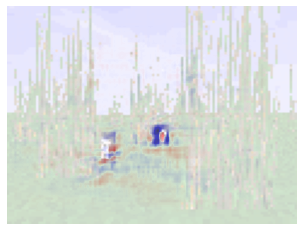

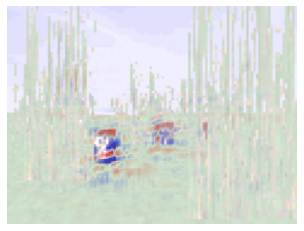

In [10]:
ims = []

for i in range(0,50,2):
    in_image = analyze_out['all_img'][:,:,:,i].transpose(2, 0, 1)
    in_image = torch.tensor(in_image).float()

    fig, ax = plt.subplots(1,1)
    attribution = att_method.attribute(in_image.to(device), target=target)
    plot_fov_att_overlay_avg(attribution, in_image, ax)

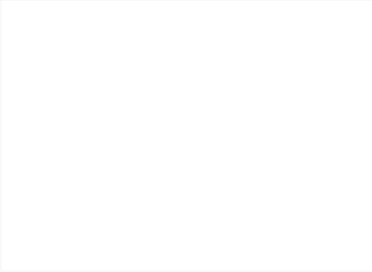

In [11]:
max_vlim = get_vlim_or_all_im(cfg, analyze_out, att_method, target, fixed_vlim=False)

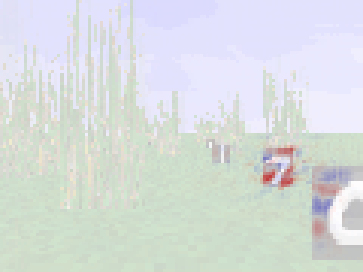

In [12]:
all_im, fig = get_vlim_or_all_im(cfg, analyze_out, att_method, target, fixed_vlim=True, vlim_value=max_vlim)

In [13]:
anim = animation.ArtistAnimation(fig, all_im, interval=100/30)
print('Saving video... (this can take some time for >10s simulations)')

t_stamp =  str(np.datetime64('now')).replace('-','').replace('T','_').replace(':', '')
pth = cfg.train_dir + "/" + cfg.experiment + f"/attribution_" + t_stamp + ".gif"

anim.save(pth, fps=30)

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving video... (this can take some time for >10s simulations)
